# Strategy composite
A composite backtesting sample that allow to run a strategy based on equities of other strategies, i.e. creating meta-strategy

In [1]:
import pandas as pd
import numpy as np

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [3]:
from yauber_backtester import Asset, Backtester, Strategy, Account, Report

# Create 100 random assets

In [4]:
def make_rnd_asset(name):
    dt_index = pd.date_range('2010-01-01', '2018-01-01')
    ser = pd.Series(np.random.normal(size=len(dt_index)), index=dt_index).cumsum()
    asset_dict = {
            'ticker': f'RND_{name}',
            'quotes': pd.DataFrame({
                'o': ser,
                'h': ser,
                'l': ser,
                'c': ser,
                'exec': ser.shift(-1),
            }, index=ser.index),
    }
    
    return Asset(**asset_dict)
    

# Simple strategy

Each day the strategy will randompy pick on of 100 assets in the universe, which has price greater MA200

In [5]:
class SimpleStrategy(Strategy):
    name = "SimpleStrategy"
    
    def calculate(self, asset: Asset) -> pd.DataFrame:
        """
        Calculates main logic of the strategy, this method must return pd.DataFrame or None (if asset is filtered at all)
        This information is used by portfolio composition stage
        """
        
        # Check if asset is greater MA200
        ohlc = asset.quotes()
                        
        ma200 =  ohlc['c'].rolling(200).mean()
        
        # Checking strategy params
        is_long = self.params.get('long', True)
        if is_long:
            is_gt_ma200 = ohlc['c'] > ma200
        else:
            is_gt_ma200 = ohlc['c'] < ma200
        
        return pd.DataFrame({
            'is_gt_ma200': is_gt_ma200,
            'ma200': ma200,           
        })

    def compose_portfolio(self, date: datetime, account: Account, asset_metrics: pd.DataFrame) -> dict:
        """
        Returns a dictionary of portfolio composition at specific 'date'
        :param date: analysis date
        :param account: actual account at the previous date (see. Account class interface)
        :param asset_metrics: composite pd.DataFrame returned by self.calculate() method at 'date'

        :return: dictionary of  {asset_class_instance: float_opened_quantity, ... }
        Notes:
        This method is about managing portfolios, you can implement asset ranking based on asset_metrics, or Money Management strategy.
        This method permits opening fractional position sizes, or opening positions with negative capital. You should explicitly manage
        all possible issues with portfolio composition and perform all checks in this method.

        You can use information returned by asset.info(date) to get all information about the asset. The backtester engine will use this
        information to retrieve execution price and costs, as well.
        """
        position = {}        
        
        # asset_metrics['is_gt_ma200']  is part of pd.DataFrame produced at calculate() method
        filtered_assets = asset_metrics['is_gt_ma200'] == 1
        
        # Randomly pick one of assets that has Close > MA(Close, 200)
        rnd_asset_idx = np.random.randint(0, len(filtered_assets.index))
        
        # Open long position on that asset
        position[filtered_assets.index[rnd_asset_idx]] = 1.0 if self.params.get('long', True) else -1.0
          
        return position
        

# Initialize and run backtester

In [6]:
strategy_long = SimpleStrategy(**{
    'params': {
        'long': True
    }
})

strategy_short = SimpleStrategy(**{
    'params': {
        'long': False
    }
})


assets100 = [make_rnd_asset(i) for i in range(100)]

# Initialize backtester class
acc_long = Backtester(assets100, 
                  strategy_long,
                  acc_name='Random100Long',
                  acc_initial_capital=1000,                  
                 ).run()

acc_short = Backtester(assets100, 
                  strategy_short,
                  acc_name='Random100Short',
                  acc_initial_capital=1000,                  
                 ).run()

### Last opened position

In [7]:
acc_long.position()

{Asset<RND_96>: RND_96 x 1.0}

In [8]:
acc_short.position()

{Asset<RND_75>: RND_75 x -1.0}

# Backtesting report

In [9]:
rpt = Report([acc_long, acc_short])

In [10]:
rpt.stats()

,Random100Long,Random100Short
MaxDD,-124.964148,-64.751763
NetProfit,899.714928,1007.518362
NumberOfTrades,2892.000000,100.000000
WinRate,0.483057,0.560000


### Long trades

In [11]:
df_trades = rpt.trades('Random100Long')
df_trades.tail()

,asset,date_entry,date_exit,side,n_transactions,wavg_price_entered,wavg_price_exited,qty_entered,qty_exited,pnl,costs
2887,RND_68,2017-12-28,2017-12-29,1,2,-58.913184,-59.068481,1.0,1.0,-0.155297,0.0
2888,RND_29,2017-12-29,2017-12-30,1,2,23.291192,23.613710,1.0,1.0,0.322518,0.0
2889,RND_98,2017-12-30,2017-12-31,1,2,178.623353,179.025723,1.0,1.0,0.402370,0.0
2890,RND_33,2017-12-31,2018-01-01,1,2,-28.764055,NaN,1.0,1.0,-2.773567,0.0
2891,RND_96,2018-01-01,2018-01-01,1,1,NaN,NaN,1.0,0.0,0.000000,0.0


### Short trades

In [12]:
df_trades = rpt.trades('Random100Short')
df_trades.tail()

,asset,date_entry,date_exit,side,n_transactions,wavg_price_entered,wavg_price_exited,qty_entered,qty_exited,pnl,costs
95,RND_37,2010-10-18,2017-11-08,-1,60,-32.333402,-32.347523,30.0,30.0,0.423617,0.0
96,RND_12,2010-10-21,2017-10-14,-1,58,57.688567,57.620656,29.0,29.0,1.969401,0.0
97,RND_86,2010-11-27,2017-10-21,-1,52,49.973148,49.816562,26.0,26.0,4.071255,0.0
98,RND_55,2011-02-11,2017-10-08,-1,70,-91.772340,-91.606691,35.0,35.0,-5.797699,0.0
99,RND_74,2011-03-26,2017-11-05,-1,48,-26.196452,-26.467776,24.0,24.0,6.511783,0.0


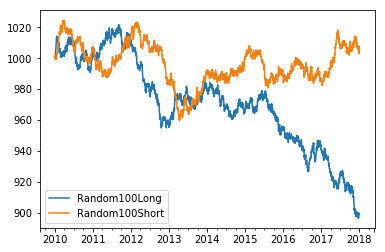

In [13]:
df_equity = rpt.series('equity')
df_equity.plot()

# Creating metastrategy
Create metastartegy that uses 'Random100Long' and 'Random100Short' accounts as underlying assets and rebalance the portfolio using these assets

In [40]:
#
# Important: beware of shorting synthetic assets, because costs can be incorrectly estimated 
#

class SimpleMetaStrategy(Strategy):
    name = "SimpleMetaStrategy"
    
    def calculate(self, asset: Asset) -> pd.DataFrame:
        """
        Calculates main logic of the strategy, this method must return pd.DataFrame or None (if asset is filtered at all)
        This information is used by portfolio composition stage
        """
        
        # Check if asset is greater MA200
        ohlc = asset.quotes()
                        
        ma200 =  ohlc['c'].rolling(200).mean()
        
        is_gt_ma200 = ohlc['c'] > ma200
        
        return pd.DataFrame({
            'is_gt_ma200': is_gt_ma200,
            'ma200': ma200,           
        })

    def compose_portfolio(self, date: datetime, account: Account, asset_metrics: pd.DataFrame) -> dict:
        """
        Returns a dictionary of portfolio composition at specific 'date'
        :param date: analysis date
        :param account: actual account at the previous date (see. Account class interface)
        :param asset_metrics: composite pd.DataFrame returned by self.calculate() method at 'date'

        :return: dictionary of  {asset_class_instance: float_opened_quantity, ... }
        Notes:
        This method is about managing portfolios, you can implement asset ranking based on asset_metrics, or Money Management strategy.
        This method permits opening fractional position sizes, or opening positions with negative capital. You should explicitly manage
        all possible issues with portfolio composition and perform all checks in this method.

        You can use information returned by asset.info(date) to get all information about the asset. The backtester engine will use this
        information to retrieve execution price and costs, as well.
        """
        position = {}        
        
        # asset_metrics['is_gt_ma200']  is part of pd.DataFrame produced at calculate() method
        filtered_assets = asset_metrics[asset_metrics['is_gt_ma200'] == 1]
        
        for asset in filtered_assets.index:            
            # Open long position on synthetic asset if its eqity is higher than 200 MA

            #
            # Important: beware of shorting synthetic assets, because costs can be incorrectly estimated 
            #
            position[asset] = 1.0
          
        return position

In [41]:
_acc_long_asset = acc_long.as_asset()
_acc_short_asset = acc_short.as_asset()

# Initialize backtester class for meta
metastrategy = SimpleMetaStrategy()
metaassets = [_acc_long_asset, _acc_short_asset]

meta_acc = Backtester(metaassets, 
                  metastrategy,
                  acc_initial_capital=1000,                  
                 ).run()

## Meta account position

In [42]:
meta_acc.position()

{}

# Meta backtesting report

In [43]:
rpt_meta = Report([meta_acc])

## Composite stats

In [44]:
rpt_meta.stats()

,Strategy<SimpleMetaStrategy>
MaxDD,-53.856512
NetProfit,971.795015
NumberOfTrades,78.000000
WinRate,0.474359


## Composite trades

In [48]:
rpt_meta.trades('Strategy<SimpleMetaStrategy>').tail()

,asset,date_entry,date_exit,side,n_transactions,wavg_price_entered,wavg_price_exited,qty_entered,qty_exited,pnl,costs
73,Random100Long,2017-06-05,2017-12-15,1,2,918.808693,900.035393,1.0,1.0,-18.773299,-0.0
74,Random100Short,2017-12-06,2017-12-16,1,2,1009.922961,1007.818860,1.0,1.0,-2.104101,-0.0
75,Random100Short,2017-12-18,2017-12-22,1,2,1006.771975,1005.511059,1.0,1.0,-1.260916,-0.0
76,Random100Short,2017-12-27,2017-12-28,1,2,1003.714105,1003.050679,1.0,1.0,-0.663426,-0.0
77,Random100Short,2017-12-30,2017-12-31,1,2,1005.572202,1007.518362,1.0,1.0,1.946160,-0.0


In [46]:
## Composite equity

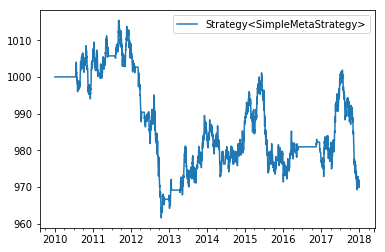

In [47]:
rpt_meta.series('equity').plot()